In [1]:
import os
import subprocess
import sys
import numpy as np
import itertools
import json
from tqdm import tqdm
from IPython.display import display, HTML
import time
import pickle
import copy
from collections import namedtuple
top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )
%load_ext autoreload
%autoreload 2
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from GenModels.GM.Distributions import Categorical, Dirichlet, TensorTransition, TensorTransitionDirichletPrior
from GenModels.research.PedigreeLoader import load
from GenModels.research.PedigreeWrappers import Pedigree, PedigreeSexMatters
from GenModels.research.Models import *

In [3]:
np.random.seed( 2 )
graphs = load()

Graph 4671AT.json is incorrect. 10
Graph 371KD.json is incorrect. 6
Graph 6030CH.json is incorrect. 25
Graph 3743MH.json is incorrect. -1
Graph 5470NG.json is incorrect. -1
Graph 928DW.json is incorrect. -5
Graph 6210HG.json is incorrect. 21
Graph 2049EE.json is incorrect. -1
Graph 1044IO.json is incorrect. -1
Graph 773SM.json is incorrect. 30
Graph 5833TK.json is incorrect. 2
Graph 5738AT.json is incorrect. Can't have an edge with no children!!!!
Graph 3427NF.json is incorrect. -1
Graph 4956RL.json is incorrect. 3
Graph 5022KK.json is incorrect. 31
Graph 5101LV.json is incorrect. 3
Graph 3420MZ.json is incorrect. 2
Graph 3515JA.json is incorrect. 2
Graph 5865MH.json is incorrect. This graph is disjoint!!!
Graph 3919MR.json is incorrect. 1
Graph 473DM.json is incorrect. 30
Graph NEI_INVPK971KPR.json is incorrect. Can't have an edge with no children!!!!
Graph 4737AL.json is incorrect. 2
Graph 5697MS.json is incorrect. 3
Graph 6199RS.json is incorrect. 14
Graph 4835MM.json is incorrect. 

In [4]:
len( graphs )

430

In [5]:
# ad_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AD' if np.array( list( graph.data.values() ) ).sum() > 1 ]
# ar_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AR' if np.array( list( graph.data.values() ) ).sum() > 1 ]
# xl_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'XL' if np.array( list( graph.data.values() ) ).sum() > 1 ]
ad_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AD' ]
ar_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AR' ]
xl_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'XL' ]

print( 'Number of graphs for AD: %d AR: %d XL: %d'%( len( ad_graphs ), len( ar_graphs ), len( xl_graphs )) )

Number of graphs for AD: 132 AR: 197 XL: 98


# Estimating E[ P( Y ) ] using Mendellian priors is biased towards autosomal recessive

In [6]:
def evaluationGraphs( graph_and_fbs, set_latent_states=False, set_root_latent_states=True ):
    assert not( set_latent_states == True and set_root_latent_states == True )
    
    graph, fbs = graph_and_fbs

    graph_sex_matters = graph if isinstance( graph, PedigreeSexMatters ) else PedigreeSexMatters.fromPedigree( graph )
    graph_sex_doesnt_matters = graph if isinstance( graph, Pedigree ) else Pedigree.fromPedigreeSexMatters( graph )
    
    ad_graph = copy.deepcopy( graph_sex_doesnt_matters )
    ar_graph = copy.deepcopy( graph_sex_doesnt_matters )
    xl_graph = copy.deepcopy( graph_sex_matters )

    if( set_root_latent_states ):
        ad_graph.useRootDiagnosisImplication( 'AD' )
        ar_graph.useRootDiagnosisImplication( 'AR' )
        xl_graph.useRootDiagnosisImplication( 'XL' )        
    if( set_latent_states ):
        ad_graph.useDiagnosisImplication( 'AD' )
        ar_graph.useDiagnosisImplication( 'AR' )
        xl_graph.useDiagnosisImplication( 'XL' )


    return ( ad_graph, fbs ), ( ar_graph, fbs ), ( xl_graph, fbs )

def onlineMeanUpdate( mean, val, N ):
    return mean + ( val - mean ) / N

def normalizedScores( ad_score, ar_score, xl_score ):
    normalizer = np.logaddexp.reduce( [ ad_score, ar_score, xl_score ] )
    probs = np.array( [ np.exp( ad_score - normalizer ), np.exp( ar_score - normalizer ), np.exp( xl_score - normalizer ) ] )
    return probs

def distributionComparison( graph, samples=400, root_strength=4, strength=4, set_latent_states=False, set_root_latent_states=True ):

    # Fill in assumptions that we can make about each graph
    ad_graph, ar_graph, xl_graph = evaluationGraphs( graph, set_latent_states=set_latent_states, set_root_latent_states=set_root_latent_states )
    
    ad_scores, ar_scores, xl_scores = [], [], []
#     ad_score, ar_score, xl_score = 0.0, 0.0, 0.0
    
    ad_eval = AutosomalDominant( [ ad_graph ], root_strength=root_strength, prior_strength=strength, method='Gibbs' )
    for i in range( samples ):
        ad_eval.sampleParams()
        ad_scores.append( ad_eval.marginal() )
#         ad_score = onlineMeanUpdate( ad_score, ad_eval.marginal(), i+1 )
    ad_eval.msg.cleanup()
    
    ar_eval = AutosomalRecessive( [ ar_graph ], root_strength=root_strength, prior_strength=strength, method='Gibbs' )
    for i in range( samples ):
        ar_eval.sampleParams()
        ar_scores.append( ar_eval.marginal() )
#         ar_score = onlineMeanUpdate( ar_score, ar_eval.marginal(), i+1 )
    ar_eval.msg.cleanup()
    
    xl_eval = XLinkedRecessive( [ xl_graph ], root_strength=root_strength, prior_strength=strength, method='Gibbs' )
    for i in range( samples ):
        xl_eval.sampleParams()
        xl_scores.append( xl_eval.marginal() )
#         xl_score = onlineMeanUpdate( xl_score, xl_eval.marginal(), i+1 )     
    xl_eval.msg.cleanup()
                        
    ad_score = np.logaddexp.reduce( ad_scores ) - np.log( len( ad_scores ) )
    ar_score = np.logaddexp.reduce( ar_scores ) - np.log( len( ar_scores ) )
    xl_score = np.logaddexp.reduce( xl_scores ) - np.log( len( xl_scores ) )
    
    
    probs = normalizedScores( ad_score, ar_score, xl_score )
#     probs = normalizedScores( ad_score, ar_score, xl_score )
    
    # Sort the scores and return the corresponding inheritance pattern
    ad_comp = ( ad_score, 'AD' )
    ar_comp = ( ar_score, 'AR' )
    xl_comp = ( xl_score, 'XL' )
    
    possibilities = [ ad_comp, ar_comp, xl_comp ]
    return sorted( possibilities, key=lambda x: x[ 0 ] )[ -1 ][ 1 ], probs, ad_scores, ar_scores, xl_scores, ad_eval, ar_eval, xl_eval

In [7]:
def classAccuracy( label, predicted, true ):
    predicted_label = predicted[ true == label ]
    return ( predicted_label == label ).sum() / predicted_label.shape[ 0 ]

In [8]:
def confusionMatrix( predicted, true, labels ):
    mat = confusion_matrix( true, predicted, labels=labels )
    print( mat )
    mat = mat / mat.sum( axis=1 )[ :, None ]
    print( mat )
    plt.imshow( mat )
    plt.colorbar()
    plt.xticks( [ 0, 1, 2 ], labels )
    plt.yticks( [ 0, 1, 2 ], labels )
    plt.show()
    print( 'Number of AD', len( [ t for t in true if t == 'AD' ] ) )
    print( 'Number of AR', len( [ t for t in true if t == 'AR' ] ) )
    print( 'Number of XL', len( [ t for t in true if t == 'XL' ] ) )
    print( 'AD Accuracy:', mat[ 0,0 ] )
    print( 'AR Accuracy:', mat[ 1,1 ] )
    print( 'XL Accuracy:', mat[ 2,2 ] )
    print( 'Cohen Kappa', cohen_kappa_score( true, predicted ) )

In [9]:
def fullPredictions( ad_graphs, ar_graphs, xl_graphs, N=100, root_strength=4, strength=4, set_latent_states=False, set_root_latent_states=True ):
    n_graphs = len( ad_graphs ) + len( ar_graphs ) + len( xl_graphs )
    results = []
    with tqdm( total=n_graphs ) as pbar:
        for graph in ad_graphs:
            res = distributionComparison( graph, samples=N, set_latent_states=set_latent_states, set_root_latent_states=set_root_latent_states, root_strength=root_strength, strength=strength )
            ip, probs, _, _, _, ad_eval, ar_eval, xl_eval = res
            results.append( ( graph, ip, 'AD', probs, ad_eval, ar_eval, xl_eval ) )
            pbar.update( 1 )

        for graph in ar_graphs:
            res = distributionComparison( graph, samples=N, set_latent_states=set_latent_states, set_root_latent_states=set_root_latent_states, root_strength=root_strength, strength=strength ) 
            ip, probs, _, _, _, ad_eval, ar_eval, xl_eval = res
            results.append( ( graph, ip, 'AR', probs, ad_eval, ar_eval, xl_eval ) )
            pbar.update( 1 )

        for graph in xl_graphs:
            res = distributionComparison( graph, samples=N, set_latent_states=set_latent_states, set_root_latent_states=set_root_latent_states, root_strength=root_strength, strength=strength ) 
            ip, probs, _, _, _, ad_eval, ar_eval, xl_eval = res
            results.append( ( graph, ip, 'XL', probs, ad_eval, ar_eval, xl_eval ) )
            pbar.update( 1 )
            
    _, predicted, true, _, _, _, _ = list( zip( *results ) )
    
    confusionMatrix( predicted, true, [ 'AD', 'AR', 'XL' ] )
    
    return results

In [10]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt

In [11]:
def softMatrix( results ):
    _, predicted, true, all_probs, _, _, _ = list( zip( *results ) )
    ad_probs = np.array( [ p for p, t in zip( all_probs, true ) if t == 'AD' ] )
    ar_probs = np.array( [ p for p, t in zip( all_probs, true ) if t == 'AR' ] )
    xl_probs = np.array( [ p for p, t in zip( all_probs, true ) if t == 'XL' ] )
    ad_soft = ad_probs.sum( axis=0 ) / ad_probs.sum()
    ar_soft = ar_probs.sum( axis=0 ) / ar_probs.sum()
    xl_soft = xl_probs.sum( axis=0 ) / xl_probs.sum()
    return np.vstack( ( ad_soft, ar_soft, xl_soft ) )

In [12]:
N = 100
# Randomly sample 10 graphs from each class to do inference on
K = 5
ind_ad = np.random.choice( len( ad_graphs ), size=min( K, len( ad_graphs ) ), replace=False )
ind_ar = np.random.choice( len( ar_graphs ), size=min( K, len( ar_graphs ) ), replace=False )
ind_xl = np.random.choice( len( xl_graphs ), size=min( K, len( xl_graphs ) ), replace=False )

In [13]:
# ad_test = [ ad_graphs[ i ] for i in ind_ad if ad_graphs[ i ][ 0 ].getNumbAffected() > 1 ]
# ar_test = [ ar_graphs[ i ] for i in ind_ar if ar_graphs[ i ][ 0 ].getNumbAffected() > 1 ]
# xl_test = [ xl_graphs[ i ] for i in ind_xl if xl_graphs[ i ][ 0 ].getNumbAffected() > 1 ]
ad_test = [ ad_graphs[ i ] for i in ind_ad ]
ar_test = [ ar_graphs[ i ] for i in ind_ar ]
xl_test = [ xl_graphs[ i ] for i in ind_xl ]
print( 'len( ad_test )', len( ad_test ) )
print( 'len( ar_test )', len( ar_test ) )
print( 'len( xl_test )', len( xl_test ) )

len( ad_test ) 5
len( ar_test ) 5
len( xl_test ) 5


100%|██████████| 427/427 [24:03<00:00,  3.55s/it]

[[77 33 22]
 [43 79 75]
 [20 13 65]]
[[0.58333333 0.25       0.16666667]
 [0.21827411 0.40101523 0.38071066]
 [0.20408163 0.13265306 0.66326531]]


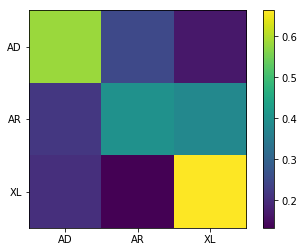

Number of AD 132
Number of AR 197
Number of XL 98
AD Accuracy: 0.5833333333333334
AR Accuracy: 0.4010152284263959
XL Accuracy: 0.6632653061224489
Cohen Kappa 0.28687939812562835


In [14]:
# results = fullPredictions( ad_graphs, ar_graphs, xl_graphs, N=3, root_strength=1000000000, strength=10000, set_latent_states=False )
# results = fullPredictions( ad_test, ar_test, xl_test, N=5, root_strength=1000000000, strength=10000, set_latent_states=False, set_root_latent_states=True )
# results = fullPredictions( ad_test, ar_test, xl_test, N=8, root_strength=1000000000, strength=1000000, set_latent_states=True, set_root_latent_states=False )
results = fullPredictions( ad_graphs, ar_graphs, xl_graphs, N=20, root_strength=1000000000, strength=1000000, set_latent_states=True, set_root_latent_states=False )

In [15]:
softMatrix( results )

array([[0.62815301, 0.22507605, 0.14677094],
       [0.31036558, 0.37706921, 0.31256521],
       [0.25883153, 0.15446314, 0.58670533]])

In [16]:
# assert 0

In [17]:
# it = iter( [ r for r in results if r[ 1 ] != r[ 2 ] ] )

In [18]:
# ( graph, _ ), predicted, true, prob, ad, ar, xl = next( it )
# print( 'Predicted:', predicted, ', True:', true, ', Prob:', prob )
# display( ad.draw( show_carrier_prob=True ) )
# print( '---------------------------------------------------------------------------------------' )
# display( ar.draw( show_carrier_prob=True ) )
# print( '---------------------------------------------------------------------------------------' )
# display( xl.draw( show_carrier_prob=True ) )

In [19]:
assert 0

AssertionError: 

In [20]:
import pickle
pickle.dump( [ r[ :-3 ] for r in results ], open( 'full_results.p', 'wb' ) )

In [21]:
sorted_graphs, predicted, true, all_probs, _, _, _ = list( zip( *results ) )

In [22]:
def separateResults( results ):
    sorted_graphs, predicted, true, all_probs, _, _, _ = list( zip( *results ) )
    ad_results, ar_results, xl_results = [], [], []
    for g, p, t, prob in zip( sorted_graphs, predicted, true, all_probs ):
        if( t == 'AD' ):
            ad_results.append( ( g, p, prob ) )
        elif( t == 'AR' ):
            ar_results.append( ( g, p, prob ) )
        else:
            xl_results.append( ( g, p, prob ) )
    return ad_results, ar_results, xl_results

In [23]:
ad_results, ar_results, xl_results = separateResults( results )

In [24]:
CONFIDENT = 0.80
SORTA_CONFIDENT = 0.50
def furtherSeparate( results, true_ip, true_ip_index ):
    confident_correct, confident_wrong, sorta_confident_correct, sorta_confident_wrong, unconfident_correct, unconfident_wrong = [], [], [], [], [], []
    for graph, predicted, prob in results:
        max_predicted = np.max( prob )
        if( predicted == true_ip ):
            if( max_predicted > CONFIDENT ):
                confident_correct.append( ( graph, predicted, true_ip, prob ) )
            elif( max_predicted > SORTA_CONFIDENT ):
                sorta_confident_correct.append( ( graph, predicted, true_ip, prob ) )
            else:
                unconfident_correct.append( ( graph, predicted, true_ip, prob ) )
        else:
            if( max_predicted > CONFIDENT ):
                confident_wrong.append( ( graph, predicted, true_ip, prob ) )
            elif( max_predicted > SORTA_CONFIDENT ):
                sorta_confident_wrong.append( ( graph, predicted, true_ip, prob ) )
            else:
                unconfident_wrong.append( ( graph, predicted, true_ip, prob ) )
    return confident_correct, confident_wrong, sorta_confident_correct, sorta_confident_wrong, unconfident_correct, unconfident_wrong

In [25]:
ad_confident_correct, ad_confident_wrong, ad_sorta_confident_correct, ad_sorta_confident_wrong, ad_unconfident_correct, ad_unconfident_wrong = furtherSeparate( ad_results, 'AD', 0 )
ar_confident_correct, ar_confident_wrong, ar_sorta_confident_correct, ar_sorta_confident_wrong, ar_unconfident_correct, ar_unconfident_wrong = furtherSeparate( ar_results, 'AR', 1 )
xl_confident_correct, xl_confident_wrong, xl_sorta_confident_correct, xl_sorta_confident_wrong, xl_unconfident_correct, xl_unconfident_wrong = furtherSeparate( xl_results, 'XL', 2 )

In [26]:
print( 'ad_confident_correct', len( ad_confident_correct ) )
print( 'ad_confident_wrong', len( ad_confident_wrong ) )
print( 'ad_sorta_confident_correct', len( ad_sorta_confident_correct ) )
print( 'ad_sorta_confident_wrong', len( ad_sorta_confident_wrong ) )
print( 'ad_unconfident_correct', len( ad_unconfident_correct ) )
print( 'ad_unconfident_wrong', len( ad_unconfident_wrong ) )
print()
print( 'ar_confident_correct', len( ar_confident_correct ) )
print( 'ar_confident_wrong', len( ar_confident_wrong ) )
print( 'ar_sorta_confident_correct', len( ar_sorta_confident_correct ) )
print( 'ar_sorta_confident_wrong', len( ar_sorta_confident_wrong ) )
print( 'ar_unconfident_correct', len( ar_unconfident_correct ) )
print( 'ar_unconfident_wrong', len( ar_unconfident_wrong ) )
print()
print( 'xl_confident_correct', len( xl_confident_correct ) )
print( 'xl_confident_wrong', len( xl_confident_wrong ) )
print( 'xl_sorta_confident_correct', len( xl_sorta_confident_correct ) )
print( 'xl_sorta_confident_wrong', len( xl_sorta_confident_wrong ) )
print( 'xl_unconfident_correct', len( xl_unconfident_correct ) )
print( 'xl_unconfident_wrong', len( xl_unconfident_wrong ) )
print()

ad_confident_correct 73
ad_confident_wrong 16
ad_sorta_confident_correct 0
ad_sorta_confident_wrong 20
ad_unconfident_correct 4
ad_unconfident_wrong 19

ar_confident_correct 24
ar_confident_wrong 37
ar_sorta_confident_correct 22
ar_sorta_confident_wrong 13
ar_unconfident_correct 33
ar_unconfident_wrong 68

xl_confident_correct 45
xl_confident_wrong 19
xl_sorta_confident_correct 6
xl_sorta_confident_wrong 3
xl_unconfident_correct 14
xl_unconfident_wrong 11



In [27]:
def confidenceLevelMetaStats( ad, ar, xl, ax ):
    # Histogram of number of affected people
    n_affected = []
    for graph, _, _, _ in itertools.chain( ad, ar, xl ):
        n_affected.append( graph[ 0 ].getNumbAffected() )
    ax.hist( n_affected )

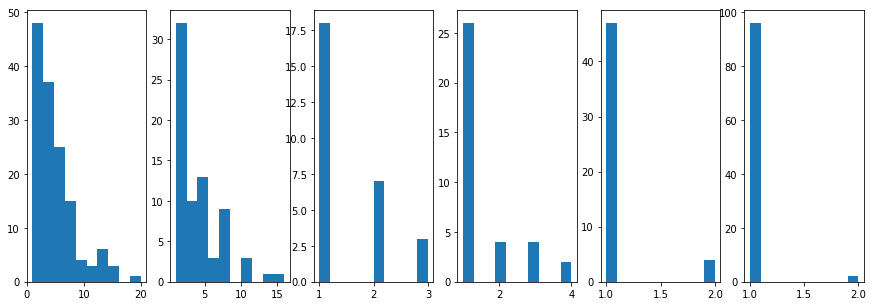

In [28]:
plt.figure( figsize=( 15, 5 ) )
axes = [ plt.subplot2grid( shape=( 1, 6 ), loc=( 0, i ), colspan=1, rowspan=1 ) for i in range( 6 ) ]
confidenceLevelMetaStats( ad_confident_correct, ar_confident_correct, xl_confident_correct, axes[ 0 ] )
confidenceLevelMetaStats( ad_confident_wrong, ar_confident_wrong, xl_confident_wrong, axes[ 1 ] )
confidenceLevelMetaStats( ad_sorta_confident_correct, ar_sorta_confident_correct, xl_sorta_confident_correct, axes[ 2 ] )
confidenceLevelMetaStats( ad_sorta_confident_wrong, ar_sorta_confident_wrong, xl_sorta_confident_wrong, axes[ 3 ] )
confidenceLevelMetaStats( ad_unconfident_correct, ar_unconfident_correct, xl_unconfident_correct, axes[ 4 ] )
confidenceLevelMetaStats( ad_unconfident_wrong, ar_unconfident_wrong, xl_unconfident_wrong, axes[ 5 ] )
plt.show()

In [29]:
def onlyConfident( ad, ar, xl ):
    res = ad + ar + xl
    print( len ( res ) )

(array([51.,  2.,  5., 10.,  6., 33.,  9.,  5.,  2.,  9.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

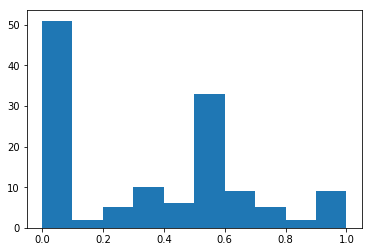

In [30]:
n_affected = []
for graph, _, _ in ad_results:
    ans = 0
    for node, attr in graph[ 0 ].attrs.items():
        if( attr[ 'affected' ] == True and attr[ 'sex' ] == 'male' ):
            ans += 1    
    if( graph[ 0 ].getNumbAffected() > 1 ):
        n_affected.append( ans / graph[ 0 ].getNumbAffected() )    
    else:
        n_affected.append( 0 )  
#     n_affected.append( graph[ 0 ].getNumbAffected() )
plt.hist( n_affected )

(array([151.,   1.,   0.,   6.,   0.,  19.,   4.,   3.,   0.,  13.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

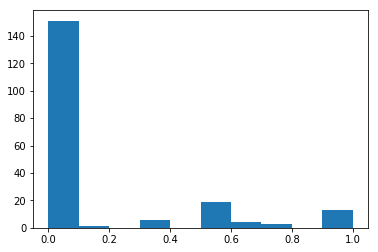

In [31]:
n_affected = []
for graph, _, _ in ar_results:
    ans = 0
    for node, attr in graph[ 0 ].attrs.items():
        if( attr[ 'affected' ] == True and attr[ 'sex' ] == 'male' ):
            ans += 1    
    if( graph[ 0 ].getNumbAffected() > 1 ):
        n_affected.append( ans / graph[ 0 ].getNumbAffected() )    
    else:
        n_affected.append( 0 )    
#     n_affected.append( graph[ 0 ].getNumbAffected() )
plt.hist( n_affected )

(array([39.,  0.,  0.,  4.,  2.,  7.,  7.,  1.,  2., 36.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

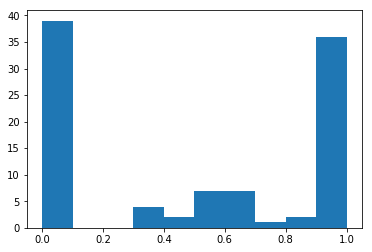

In [32]:
n_affected = []
for graph, _, _ in xl_results:
    ans = 0
    for node, attr in graph[ 0 ].attrs.items():
        if( attr[ 'affected' ] == True and attr[ 'sex' ] == 'male' ):
            ans += 1    
    if( graph[ 0 ].getNumbAffected() > 1 ):
        n_affected.append( ans / graph[ 0 ].getNumbAffected() )    
    else:
        n_affected.append( 0 )     
#     n_affected.append( graph[ 0 ].getNumbAffected() )
plt.hist( n_affected )

In [33]:
def numbAffectedMales( graph ):
    ans = 0
    for node, attr in graph.attrs.items():
        if( attr[ 'affected' ] == 1 and attr[ 'sex' ] == 'male' ):
            ans += 1
    return ans / graph.getNumbAffected()

In [51]:
true = []
predicted = []
for ( graph, _ ), pred, tru, prob in results:
    if( np.max( prob ) < 0.44 ):
        continue

    if( graph.getNumbAffected() == 1 and np.max( prob ) < 0.58 ):
        predicted.append( 'AR' )
    else:
        predicted.append( pred )
    true.append( tru )
predicted = np.array( predicted )
true = np.array( true )

[[73 34  9]
 [22 86 19]
 [15 18 48]]
[[0.62931034 0.29310345 0.07758621]
 [0.17322835 0.67716535 0.1496063 ]
 [0.18518519 0.22222222 0.59259259]]


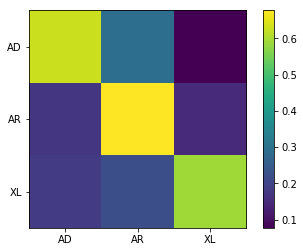

Number of AD 116
Number of AR 127
Number of XL 81
AD Accuracy: 0.6293103448275862
AR Accuracy: 0.6771653543307087
XL Accuracy: 0.5925925925925926
Cohen Kappa 0.44687308489217026


In [52]:
confusionMatrix( predicted, true, [ 'AD', 'AR', 'XL' ] )

In [36]:
over_one_affected = [ r for r in results if r[ 0 ][ 0 ].getNumbAffected() > 1 ]

[[73  8  8]
 [23 22 13]
 [15  3 44]]
[[0.82022472 0.08988764 0.08988764]
 [0.39655172 0.37931034 0.22413793]
 [0.24193548 0.0483871  0.70967742]]


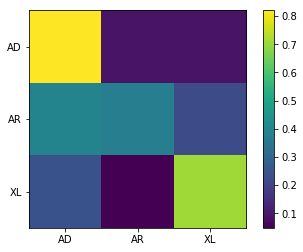

Number of AD 89
Number of AR 58
Number of XL 62
AD Accuracy: 0.8202247191011236
AR Accuracy: 0.3793103448275862
XL Accuracy: 0.7096774193548387
Cohen Kappa 0.47483667169215305


In [37]:
_, predicted, true, _, _, _, _ = list( zip( *over_one_affected ) )
predicted = np.array( predicted )
true = np.array( true )

labels = [ 'AD', 'AR', 'XL' ]
confusionMatrix( predicted, true, labels )

In [38]:
def confidenceEval( all_of_level ):
    predicted, true = [], []
    for graph, pred, tru, probs in itertools.chain( *all_of_level ):
        predicted.append( pred )
        true.append( tru )
    predicted = np.array( predicted )
    true = np.array( true )
    confusionMatrix( predicted, true, labels )

[[73 12  4]
 [21 24 16]
 [15  4 45]]
[[0.82022472 0.13483146 0.04494382]
 [0.3442623  0.39344262 0.26229508]
 [0.234375   0.0625     0.703125  ]]


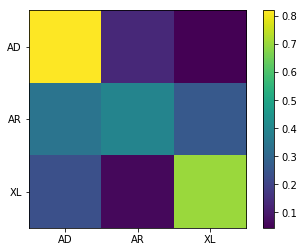

Number of AD 89
Number of AR 61
Number of XL 64
AD Accuracy: 0.8202247191011236
AR Accuracy: 0.39344262295081966
XL Accuracy: 0.703125
Cohen Kappa 0.47760637396168837


In [39]:
all_confident = ad_confident_correct, ad_confident_wrong, ar_confident_correct, ar_confident_wrong, xl_confident_correct, xl_confident_wrong
confidenceEval( all_confident )

[[ 0 12  8]
 [ 1 22 12]
 [ 1  2  6]]
[[0.         0.6        0.4       ]
 [0.02857143 0.62857143 0.34285714]
 [0.11111111 0.22222222 0.66666667]]


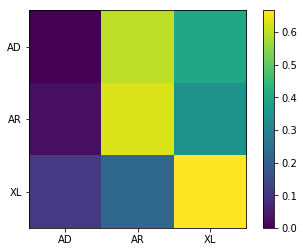

Number of AD 20
Number of AR 35
Number of XL 9
AD Accuracy: 0.0
AR Accuracy: 0.6285714285714286
XL Accuracy: 0.6666666666666666
Cohen Kappa 0.10070257611241218


In [40]:
all_sorta_confident = ad_sorta_confident_correct, ad_sorta_confident_wrong, ar_sorta_confident_correct, ar_sorta_confident_wrong, xl_sorta_confident_correct, xl_sorta_confident_wrong
confidenceEval( all_sorta_confident )

[[ 4  9 10]
 [21 33 47]
 [ 4  7 14]]
[[0.17391304 0.39130435 0.43478261]
 [0.20792079 0.32673267 0.46534653]
 [0.16       0.28       0.56      ]]


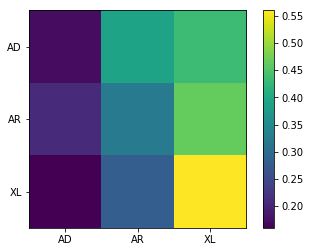

Number of AD 23
Number of AR 101
Number of XL 25
AD Accuracy: 0.17391304347826086
AR Accuracy: 0.32673267326732675
XL Accuracy: 0.56
Cohen Kappa 0.014044564483457145


In [41]:
all_unconfident = ad_unconfident_correct, ad_unconfident_wrong, ar_unconfident_correct, ar_unconfident_wrong, xl_unconfident_correct, xl_unconfident_wrong
confidenceEval( all_unconfident )

In [42]:
# assert 0

In [43]:
def saveGraphs( results, folder_name ):
    for ( graph, fbs ), predicted, _, prob in results:
        d = graph.draw()
        name = folder_name + '/%s__AD_%1.2f_AR_%1.2f_XL_%1.2f'%( graph.studyID, prob[ 0 ], prob[ 1 ], prob[ 2 ] )
        d.render( name, view=False, cleanup=True )

In [44]:
saveGraphs( ad_confident_correct, 'ad_confident_correct' )
saveGraphs( ad_confident_wrong, 'ad_confident_wrong' )
saveGraphs( ad_sorta_confident_correct, 'ad_sorta_confident_correct' )
saveGraphs( ad_sorta_confident_wrong, 'ad_sorta_confident_wrong' )
saveGraphs( ad_unconfident_correct, 'ad_unconfident_correct' )
saveGraphs( ad_unconfident_wrong, 'ad_unconfident_wrong' )

saveGraphs( ar_confident_correct, 'ar_confident_correct' )
saveGraphs( ar_confident_wrong, 'ar_confident_wrong' )
saveGraphs( ar_sorta_confident_correct, 'ar_sorta_confident_correct' )
saveGraphs( ar_sorta_confident_wrong, 'ar_sorta_confident_wrong' )
saveGraphs( ar_unconfident_correct, 'ar_unconfident_correct' )
saveGraphs( ar_unconfident_wrong, 'ar_unconfident_wrong' )

saveGraphs( xl_confident_correct, 'xl_confident_correct' )
saveGraphs( xl_confident_wrong, 'xl_confident_wrong' )
saveGraphs( xl_sorta_confident_correct, 'xl_sorta_confident_correct' )
saveGraphs( xl_sorta_confident_wrong, 'xl_sorta_confident_wrong' )
saveGraphs( xl_unconfident_correct, 'xl_unconfident_correct' )
saveGraphs( xl_unconfident_wrong, 'xl_unconfident_wrong' )

In [45]:
assert 0, 'This is the end of the analysis with only pedigree data'

AssertionError: This is the end of the analysis with only pedigree data

In [46]:
import pandas as pd 

df = pd.read_csv( 'pedigreeAnswers.csv' )
df_labels = pd.read_csv( 'Complete_pedigree_data.csv' )

# Set the labels for the regular df
for studyID, IP in df_labels[ [ 'Patient ID', 'Inheritance Pattern' ] ].values:
    if( studyID in df[ 'Patient ID' ].values ):
        index = df.index[ df[ 'Patient ID' ] == studyID ][ 0 ]
        df.loc[ index, 'IP' ] = IP

# Drop nan inheritance patterns
bad_mask = df[ 'IP' ].isna()
df = df[ ~bad_mask ]

# Load the ghmm results
results = pickle.load( open( 'full_results.p', 'rb' ) )

# Add the extra features from the ghmm
for ( graph, _ ), _, _, p in sorted( results, key=lambda x: x[ 0 ][ 0 ].studyID ):
    if( graph.studyID in df[ 'Patient ID' ].values ):
        index = df.index[ df[ 'Patient ID' ] == graph.studyID ][ 0 ]
        df.loc[ index, 'AD_Prob' ] = p[ 0 ]
        df.loc[ index, 'AR_Prob' ] = p[ 1 ]
        df.loc[ index, 'XL_Prob' ] = p[ 2 ]
        df.loc[ index, 'nMales' ] = len( [ 1 for n in graph.nodes if graph.attrs[ n ][ 'sex' ] == 'male' ] )
        df.loc[ index, 'nFemales' ] = len( [ 1 for n in graph.nodes if graph.attrs[ n ][ 'sex' ] == 'female' ] )
        df.loc[ index, 'nUnknowns' ] = len( [ 1 for n in graph.nodes if graph.attrs[ n ][ 'sex' ] == 'unknown' ] )
        if( not graph.inheritancePattern == df.loc[ index, 'IP' ] ):
            print( 'graph.inheritancePattern', graph.inheritancePattern )
            print( 'df.loc[ index, \'IP\' ]', df.loc[ index, 'IP' ] )
            assert 0

# Use these features
keep_cols = [ 'Patient ID',
              'numAff',
              'multGenAff',
              'MAffSon',
              'MAffDau',
              'skipping',
              'sibAff',
              'halfSibAff',
              'cousAff',
              'MFAff',
              'ons20M',
              'multDx',
              'consang',
              'nMales',
              'nFemales',
              'nUnknowns',
              'AD_Prob',
              'AR_Prob',
              'XL_Prob',
              'IP' ]

# Drop the rows that we don't have ghmm results for
df = df[ keep_cols ].dropna()
df = df.set_index( 'Patient ID' )

# Drop inheritance patterns that aren't AD, AR or XL
mask = df[ 'IP' ] == 'AD'
mask |= df[ 'IP' ] == 'AR'
mask |= df[ 'IP' ] == 'XL'
df = df[ mask ]

In [47]:
df

,numAff,multGenAff,MAffSon,MAffDau,skipping,sibAff,halfSibAff,cousAff,MFAff,ons20M,multDx,consang,nMales,nFemales,nUnknowns,AD_Prob,AR_Prob,XL_Prob,IP
Patient ID,,,,,,,,,,,,,,,,,,,
1022AS,1,False,False,False,1,1,1,1,3,False,False,False,14.0,13.0,4.0,1.952661e-01,8.047339e-01,4.261081e-12,AR
1036RC,1,False,False,False,1,1,1,1,2,Unknown,False,False,9.0,8.0,0.0,2.944810e-01,3.381087e-01,3.674103e-01,AR
1046DA,4,True,False,False,3,1,1,1,3,False,False,False,9.0,10.0,3.0,1.000000e+00,6.022719e-10,1.666467e-27,AD
1075NP,3,True,False,False,2,3,1,1,1,True,True,False,19.0,17.0,4.0,3.753376e-01,3.796948e-01,2.449676e-01,AR
1084LN,8,True,True,True,2,3,1,3,1,Unknown,False,False,32.0,24.0,12.0,1.000000e+00,2.253291e-19,3.500799e-34,AD
1089JB,6,True,False,False,2,1,1,2,2,Unknown,True,False,22.0,12.0,2.0,9.807848e-12,4.327722e-09,1.000000e+00,XL
164KD,2,False,False,False,1,1,1,2,1,True,True,False,11.0,14.0,0.0,3.504870e-01,2.036650e-01,4.458480e-01,AR
167MW,3,True,False,False,1,3,1,1,3,False,True,False,15.0,19.0,3.0,7.327454e-02,9.267245e-01,9.460936e-07,AR
189DC,2,True,False,True,1,1,1,1,1,Unknown,False,False,18.0,18.0,10.0,9.999302e-01,3.948129e-05,3.028360e-05,AD


In [53]:
df_labels = pd.read_csv( 'Complete_pedigree_data.csv' )

In [54]:
df_labels

,Patient ID,Gene,Inheritance Pattern,Source,Correct?,Digitizer,Notes for Issues,Notes for solution,Date of pedigree photo,Pedigree photo filename,JSON filename,Mbox filename(eyeGene)
0,1011MB,ABCA4,AR,KEC,Y,Ben,NaN,NaN,summer 2017,1011MB.JPG,1011MB.json,NaN
1,1022AS,CNGB3,AR,KEC,Y,Ben,NaN,NaN,summer 2017,1022AS.JPG,1022AS.json,NaN
2,1036RC,CNGB3,AR,KEC,Y,Ben,NaN,NaN,summer 2017,1036RC.JPG,1036RC.json,NaN
3,1038CG,XLRS1,XL,KEC,Y,Ben,Is RS a valid disease,yes it is a disease,summer 2017,1038CG.JPG,1038CG.json,NaN
4,1044IO,CNGA3,AR,KEC,Y,Ben,There are two different shadings but it says s...,mark similar as unknown,summer 2017,1044IO.JPG,1044IO.json,NaN
5,1046DA,RP1,AD,KEC,Y,Ben,NaN,NaN,summer 2017,1046DA.JPG,1046DA.json,NaN
6,1071MP,Rho,AD,KEC,N,Ben,old one won't load. looking into issue after f...,NaN,summer 2017,1071MP.JPG,1071MP.json,NaN
7,1075NP,CNGA3,AR,KEC,Y,Ben,NaN,NaN,summer 2017,1075NP.JPG,1075NP.json,NaN
8,1079JM,ABCA4,AR,KEC,Y,Ben,NaN,NaN,summer 2017,1079JM.JPG,1079JM.json,NaN
9,1083BF,ABCA4,AR,KEC,Y,Ben,NaN,NaN,summer 2017,1083BF.JPG,1083BF.json,NaN


In [62]:
( df_labels[ 'Inheritance Pattern' ] == 'other' ).sum()

1

In [63]:
import autograd

In [65]:
autograd.numpy.broadcast_to

<function autograd.tracer.primitive.<locals>.f_wrapped(*args, **kwargs)>